# Display current agent performance

Import libraries:

In [1]:
import numpy as np
import tensorflow as tf
import gym
gym.logger.set_level(40)
import matplotlib.pyplot as plt

c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Watch agents play an episode of each game

Let's define a list of all the games for which we have a trained agent ready

In [2]:
game_name = ['CartPole', 'MountainCar', 'LunarLander', 'Acrobot']
version = ['v0', 'v0', 'v2', 'v1']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

Now for each game, load the trained model and run one episode. I'm adding a limit for the maximal number of steps as some of the games can have very long episodes

In [3]:
for i in range(len(game_name)):
    
    ep_reward = []
    env = gym.make(game_name[i] + '-' + version[i]) # Create an instance of the game environment
    env._max_episode_steps = 1000 # Limit maximal number of steps per episode

    with tf.Session() as sess:

        '''Load model'''
        saver = tf.train.import_meta_graph("models/" + game_name[i] + "/model.ckpt.meta") # import saved graph
        saver.restore(sess, "models/" + game_name[i] + "/model.ckpt") # load model parameters
        graph = tf.get_default_graph() # create a graph instance containing all the tensors
        action_prob_dist = graph.get_tensor_by_name("Action_PDF/softamx:0") # get the action PDF output tensor
        input_ = graph.get_tensor_by_name("input:0") # get the input tensor

        '''Play an episode according to the model'''
        obs = env.reset() # Reset env and save observation
        t = 0
        while True:
            env.render() # Render game
            # Use our model to create a probability distribution of actions based on observation
            apd = np.squeeze(sess.run(action_prob_dist, feed_dict={input_ : obs.reshape((1,len(obs)))}))
            # Choose an action out of the PDF and take action
            action = np.random.choice(np.arange(len(apd)), p = apd)
            obs, reward, done, info = env.step(action)
            ep_reward.append(reward) # Append step reward to episode rewards list
            t = t+1
            if done:
                print("Game ended after {} steps".format(t+1))
                print("Total reward earned in this episode: {:0.2f}".format(sum(ep_reward)))
                break
    env.close()
    tf.reset_default_graph() # Reset graph for allowing next model to be loaded

INFO:tensorflow:Restoring parameters from models/CartPole/model.ckpt
Game ended after 1001 steps
Total reward earned in this episode: 1000.00
INFO:tensorflow:Restoring parameters from models/MountainCar/model.ckpt
Game ended after 540 steps
Total reward earned in this episode: -539.00
INFO:tensorflow:Restoring parameters from models/LunarLander/model.ckpt
Game ended after 294 steps
Total reward earned in this episode: 260.36
INFO:tensorflow:Restoring parameters from models/Acrobot/model.ckpt
Game ended after 136 steps
Total reward earned in this episode: -134.00


### Evaluate agents performance

Game solving thresholds (from [OpenAI wiki](https://github.com/openai/gym/wiki/Leaderboard)):

* CartPole-v0 defines "solving" as getting average reward of 195.0 over 100 consecutive trials
* MountainCar-v0 defines "solving" as getting average reward of -110.0 over 100 consecutive trials
* LunarLander-v2 defines "solving" as getting average reward of 200 over 100 consecutive trials
* Acrobot-v1 is an unsolved environment, which means it does not have a specified reward threshold at which it's considered solved


In order to get a better sense of the agets performance we need more statisics. We'll let each agent paly 100 episodes, compute the mean and std, and plot a histogram of the results:

Mean episode reward in CartPole is: 1000 ± 0
Mean episode reward in MountainCar is: -672 ± 178
Mean episode reward in LunarLander is: 223 ± 95
Mean episode reward in Acrobot is: -149 ± 29


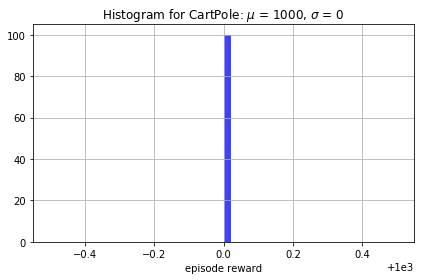

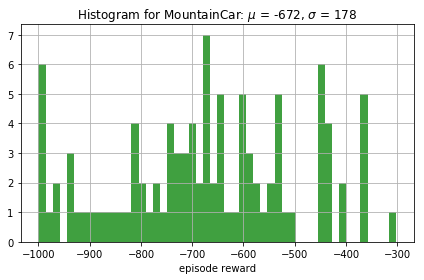

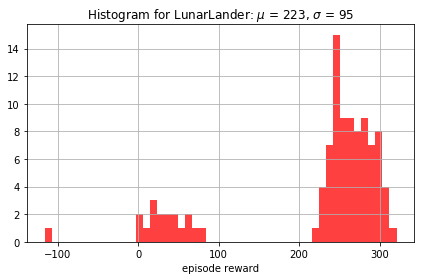

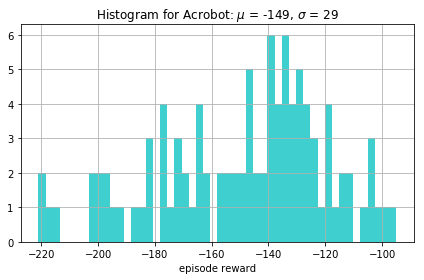

In [4]:
tf.logging.set_verbosity(tf.logging.ERROR) # Hide loading models INFO messages
for i in range(len(game_name)):
    sess = tf.Session()
    
    '''Define environment'''
    env = gym.make(game_name[i] + '-' + version[i]) # Create an instance of the game environment
    env._max_episode_steps = 1000 # Limit maximal number of steps per episode
    
    '''Load model'''
    saver = tf.train.import_meta_graph("models/" + game_name[i] + "/model.ckpt.meta") # import saved graph
    saver.restore(sess, "models/" + game_name[i] + "/model.ckpt") # load model parameters
    graph = tf.get_default_graph() # create a graph instance containing all the tensors
    action_prob_dist = graph.get_tensor_by_name("Action_PDF/softamx:0") # get the action PDF output tensor
    input_ = graph.get_tensor_by_name("input:0") # get the input tensor
    
    total_reward = []
    for j in range(100):
        ep_reward = []
        '''Play an episode according to the model'''
        obs = env.reset() # Reset env and save observation
        t = 0
        while True:
            # Use our model to create a probability distribution of actions based on observation
            apd = np.squeeze(sess.run(action_prob_dist, feed_dict={input_ : obs.reshape((1,len(obs)))}))
            # Choose an action out of the PDF and take action
            action = np.random.choice(np.arange(len(apd)), p = apd)
            obs, reward, done, info = env.step(action)
            ep_reward.append(reward) # Append step reward to episode rewards list
            t = t+1
            if done:
                total_reward.append(np.sum(ep_reward)) # Append the total reward in this episode 
                break
    sess.close()
    mean_reward = int(np.mean(total_reward)) # Compute the mean reward per episode 
    std_reward = int(np.std(total_reward)) # Compute std of the reward over episodes
    print("Mean episode reward in " + game_name[i] + " is: {:d} ".format(mean_reward) 
           + u"\u00B1" + " {:d}".format(std_reward))
    
    '''Plot historagms'''
    plt.figure()
    plt.hist(total_reward, 50, facecolor = colors[i] ,alpha = 0.75)
    plt.title("Histogram for " + game_name[i] + ": " + r"$\mu$ =" + " {:d}, ".format(mean_reward) 
               + r"$\sigma$ =" + " {:d}".format(std_reward))
    plt.xlabel("episode reward")
    plt.grid(True)
    plt.tight_layout()
    
    tf.reset_default_graph() # Reset graph for allowing next model to be loaded